The libraries and the cifar10 dataset are loaded. The cifar10 dataset contains 10 classes with images of animals and vehicles. The loaded data is normalized to a range from -1 to 1. The testing data is not needed since we are trying to generate data

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values to [-1, 1]
x_train = (x_train.astype('float32') - 127.5) / 127.5

# Reshape data to have 3 channels
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3).astype('float32')

To generate new instances, a generator and a discriminator model are defined. The task of the generator model is to generate a new instance and the discriminator model is trying to predict whether the generated instance is generated or real

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the generator network
def make_generator_model():
    model = keras.Sequential([
        layers.Dense(4*4*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((4, 4, 256)),
        layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Define the discriminator network
def make_discriminator_model():
    model = keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model


Before the training is done, custom loss functions for the two models are designed

In [3]:
# Define loss functions
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

# Define the generator loss function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the discriminator loss function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

A function for the training loop and the optimizers are defined and the models are created. In addition, a function to generate and save the images from the generator network is defined

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Define the generator and discriminator networks
generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

# Define the training loop
@tf.function
def train_step(images):
    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Define a function to generate images from the generator network
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2)
        plt.axis('off')
    plt.savefig('tje_image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In the end, the training data is shufflled and used for training. The combined architecture is trained for 50 epochs. After five epochs, the generated images are shown

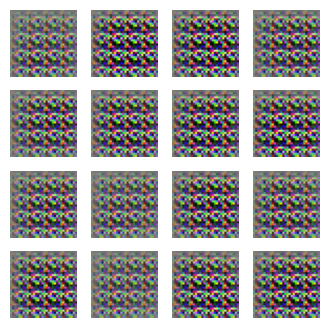

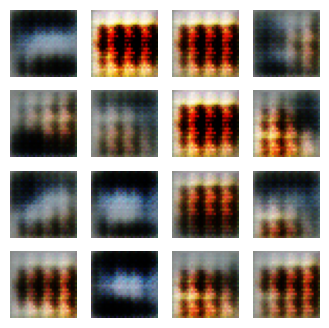

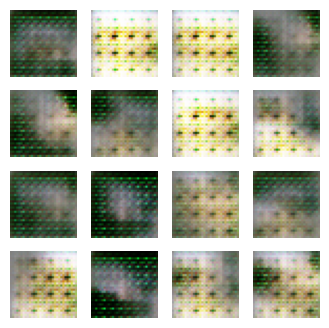

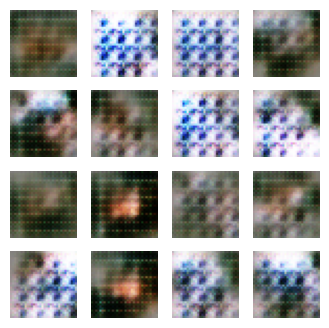

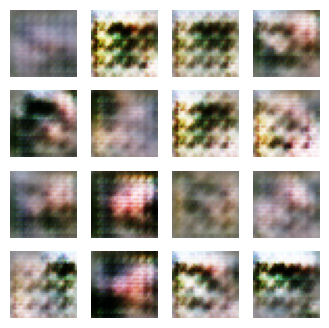

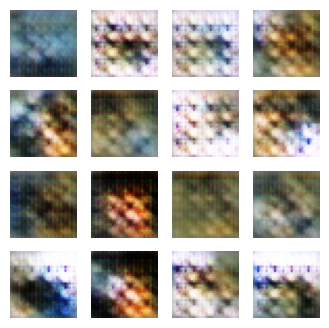

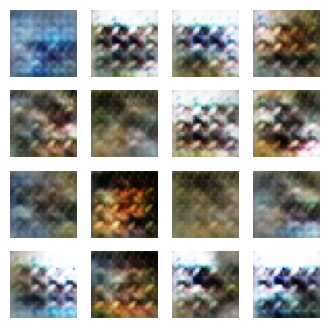

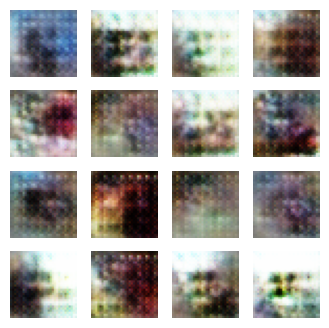

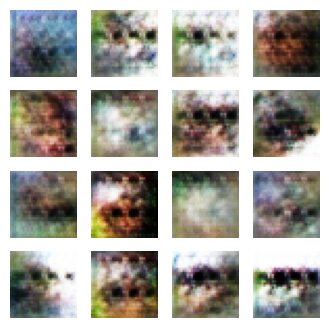

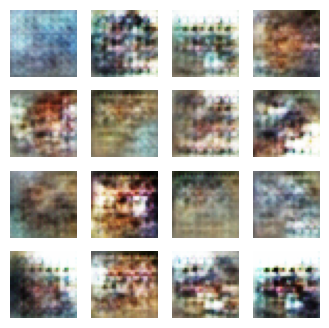

In [4]:
# Train the DCGAN

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(256)

# Generate random noise for visualization
test_noise = tf.random.normal([16, 100])

# Train the DCGAN for 50 epochs
epochs = 50
for epoch in range(epochs):
    for image_batch in train_dataset:
        train_step(image_batch)

    if epoch % 5 == 0:
        generate_and_save_images(generator, epoch, test_noise)


As can be seen in the previous results, the generator is changing the output kind of. This dataset is really hard to generate instances for. The previous cell ran for 2 hours. The figures show, that a progress towards images that might look like being from the cifar10 was done. The results can be improved by training longer.

For comparison, some of the real instances are shown below

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

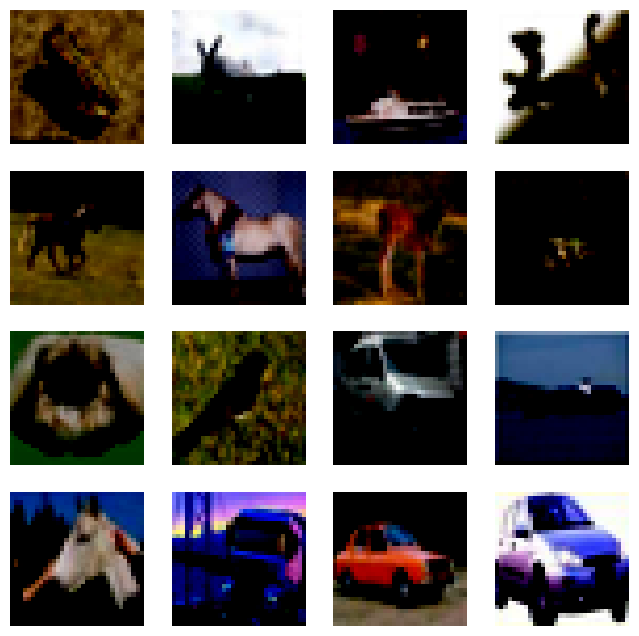

In [5]:
import matplotlib.pyplot as plt

# Choose a random batch of images from the original dataset
original_images = next(iter(train_dataset))

# Plot the original images
fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharey=True, sharex=True)
cnt = 0
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(original_images[cnt])
        axs[i,j].axis('off')
        cnt += 1
plt.show()
